# Surface Code Encoding

In [121]:
%load_ext autoreload
%autoreload 2

In [13]:
from qiskit import QuantumCircuit, execute, QuantumRegister, ClassicalRegister, Aer
import matplotlib.pyplot as plt

## Stabilizer Eigenstates

Following Fowler et. al [1], we see that the two-qubit operators $Z_a Z_b$ commute with $X_a X_b$. The eigenstates of these *stabilizers* are the Bell states (**Table II**):

<p align="center">
<img width="245" alt="stabilizer-eigenstates" src="https://user-images.githubusercontent.com/293681/88832601-0f9a5800-d19f-11ea-88fe-a8191e21a67e.png">
</p>
**** something about ancilla qubit and error measurement as projector ****

[1] Fowler, A. G., Mariantoni, M., Martinis, J. M. & Cleland, A. N. Surface codes: Towards practical large-scale quantum computation. Phys. Rev. A 86, 032324 (2012).


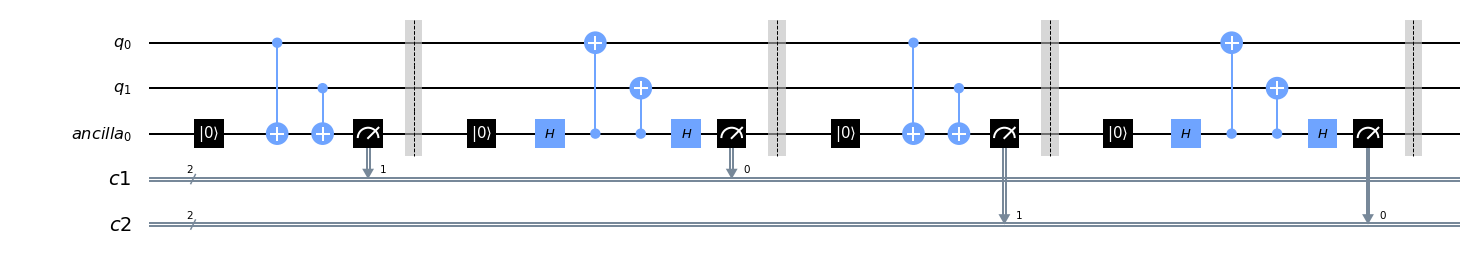

In [87]:
qr = QuantumRegister(2, name='q')
an = QuantumRegister(1, name='ancilla')

rounds = 2
measurements = [ClassicalRegister(2, name="c{}".format(i+1)) for i in range(rounds)]

circ = QuantumCircuit(qr, an, *measurements)

def ZZ_meas(round):
    circ.reset(an)
    circ.cx(0, 2)
    circ.cx(1, 2)
    circ.measure(an, measurements[round][1])
    circ.barrier()

def XX_meas(round):
    circ.reset(an)
    circ.h(an)
    circ.cx(an, 0)
    circ.cx(an, 1)
    circ.h(an)
    circ.measure(an, measurements[round][0])
    circ.barrier()

for i in range(rounds):
    ZZ_meas(i)
    XX_meas(i)

circ.draw(output='mpl', fold=35)

Running this circuit on the four Bell states, and the stabilizer is stable:

Bell state ii: {'00 00': 1}
Bell state ix: {'10 10': 1}
Bell state xi: {'01 01': 1}
Bell state xx: {'11 11': 1}


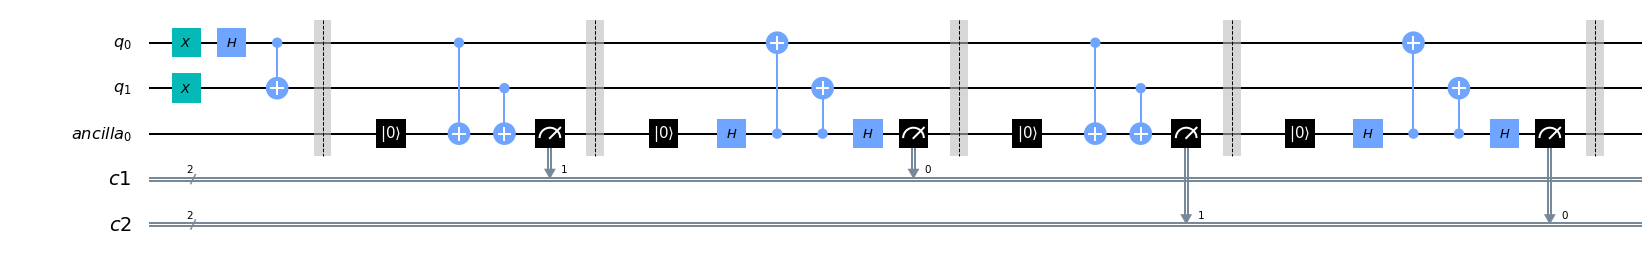

In [88]:
import itertools
for q0_gate, q1_gate in itertools.product(["i", "x"], repeat=2):  
    test_circ = QuantumCircuit(qr, an, *measurements)
    
    # Set up our Bell "generator" states
    getattr(test_circ, q0_gate)(0) #i.e. test_circ.i(0) or test_circ.x(0)
    getattr(test_circ, q1_gate)(1) #i.e. test_circ.i(1) or test_circ.x(1)
    
    # Create Bell state
    test_circ.h(0)
    test_circ.cx(0, 1)
    test_circ.barrier()

    test_circ = test_circ.combine(circ)
    print("Bell state %s%s:" % (q0_gate, q1_gate), execute(test_circ, Aer.get_backend('qasm_simulator'), shots=1).result().get_counts())
# Final Circuit Example
test_circ.draw(output='mpl', fold=35)

Even though our projective measurement is only on the ancilla qubit, all of our qubits are entangled through the stabilizer measurement process. Thus, the ancilla measurement *does* induce back-action on our actual qubit. For example, let's run the circuit on the $|00\rangle$ state, which is **not** a mutual eigenstate of the stabilizers:

In [89]:
execute(circ, Aer.get_backend('qasm_simulator')).result().get_counts()

{'00 00': 511, '01 01': 513}

Roughly half of the time we get `00 00`, and the other half `01 01`. If you go through the circuit, it's straightforward to verify that the first $XX$ measurement will project $|00\rangle$ into either the $|00\rangle$ + $|11\rangle$ or $|00\rangle$ - $|11\rangle$ Bell state (and their respective stabilizer eigenvalues).

In the absence of errors, subsequent measurements of the eigenvalue after the first stabilizer measurement will remain the same! This is known as the *quiescent state* of the code, and is an important part of the initialization process for surface codes.

## Manual d=3 Surface Code with 17 Qubits

Following [2], we can generalize this into a d=3 rotated surface code with 9 data qubits and 8 ancillas. Please see the reference for details about how the circuit is constructed, including a subtlety with the direction of stabilzer measurements in each cell.

[2] Tomita, Y. & Svore, K. M. Low-distance surface codes under realistic quantum noise. Phys. Rev. A 90, 062320 (2014).

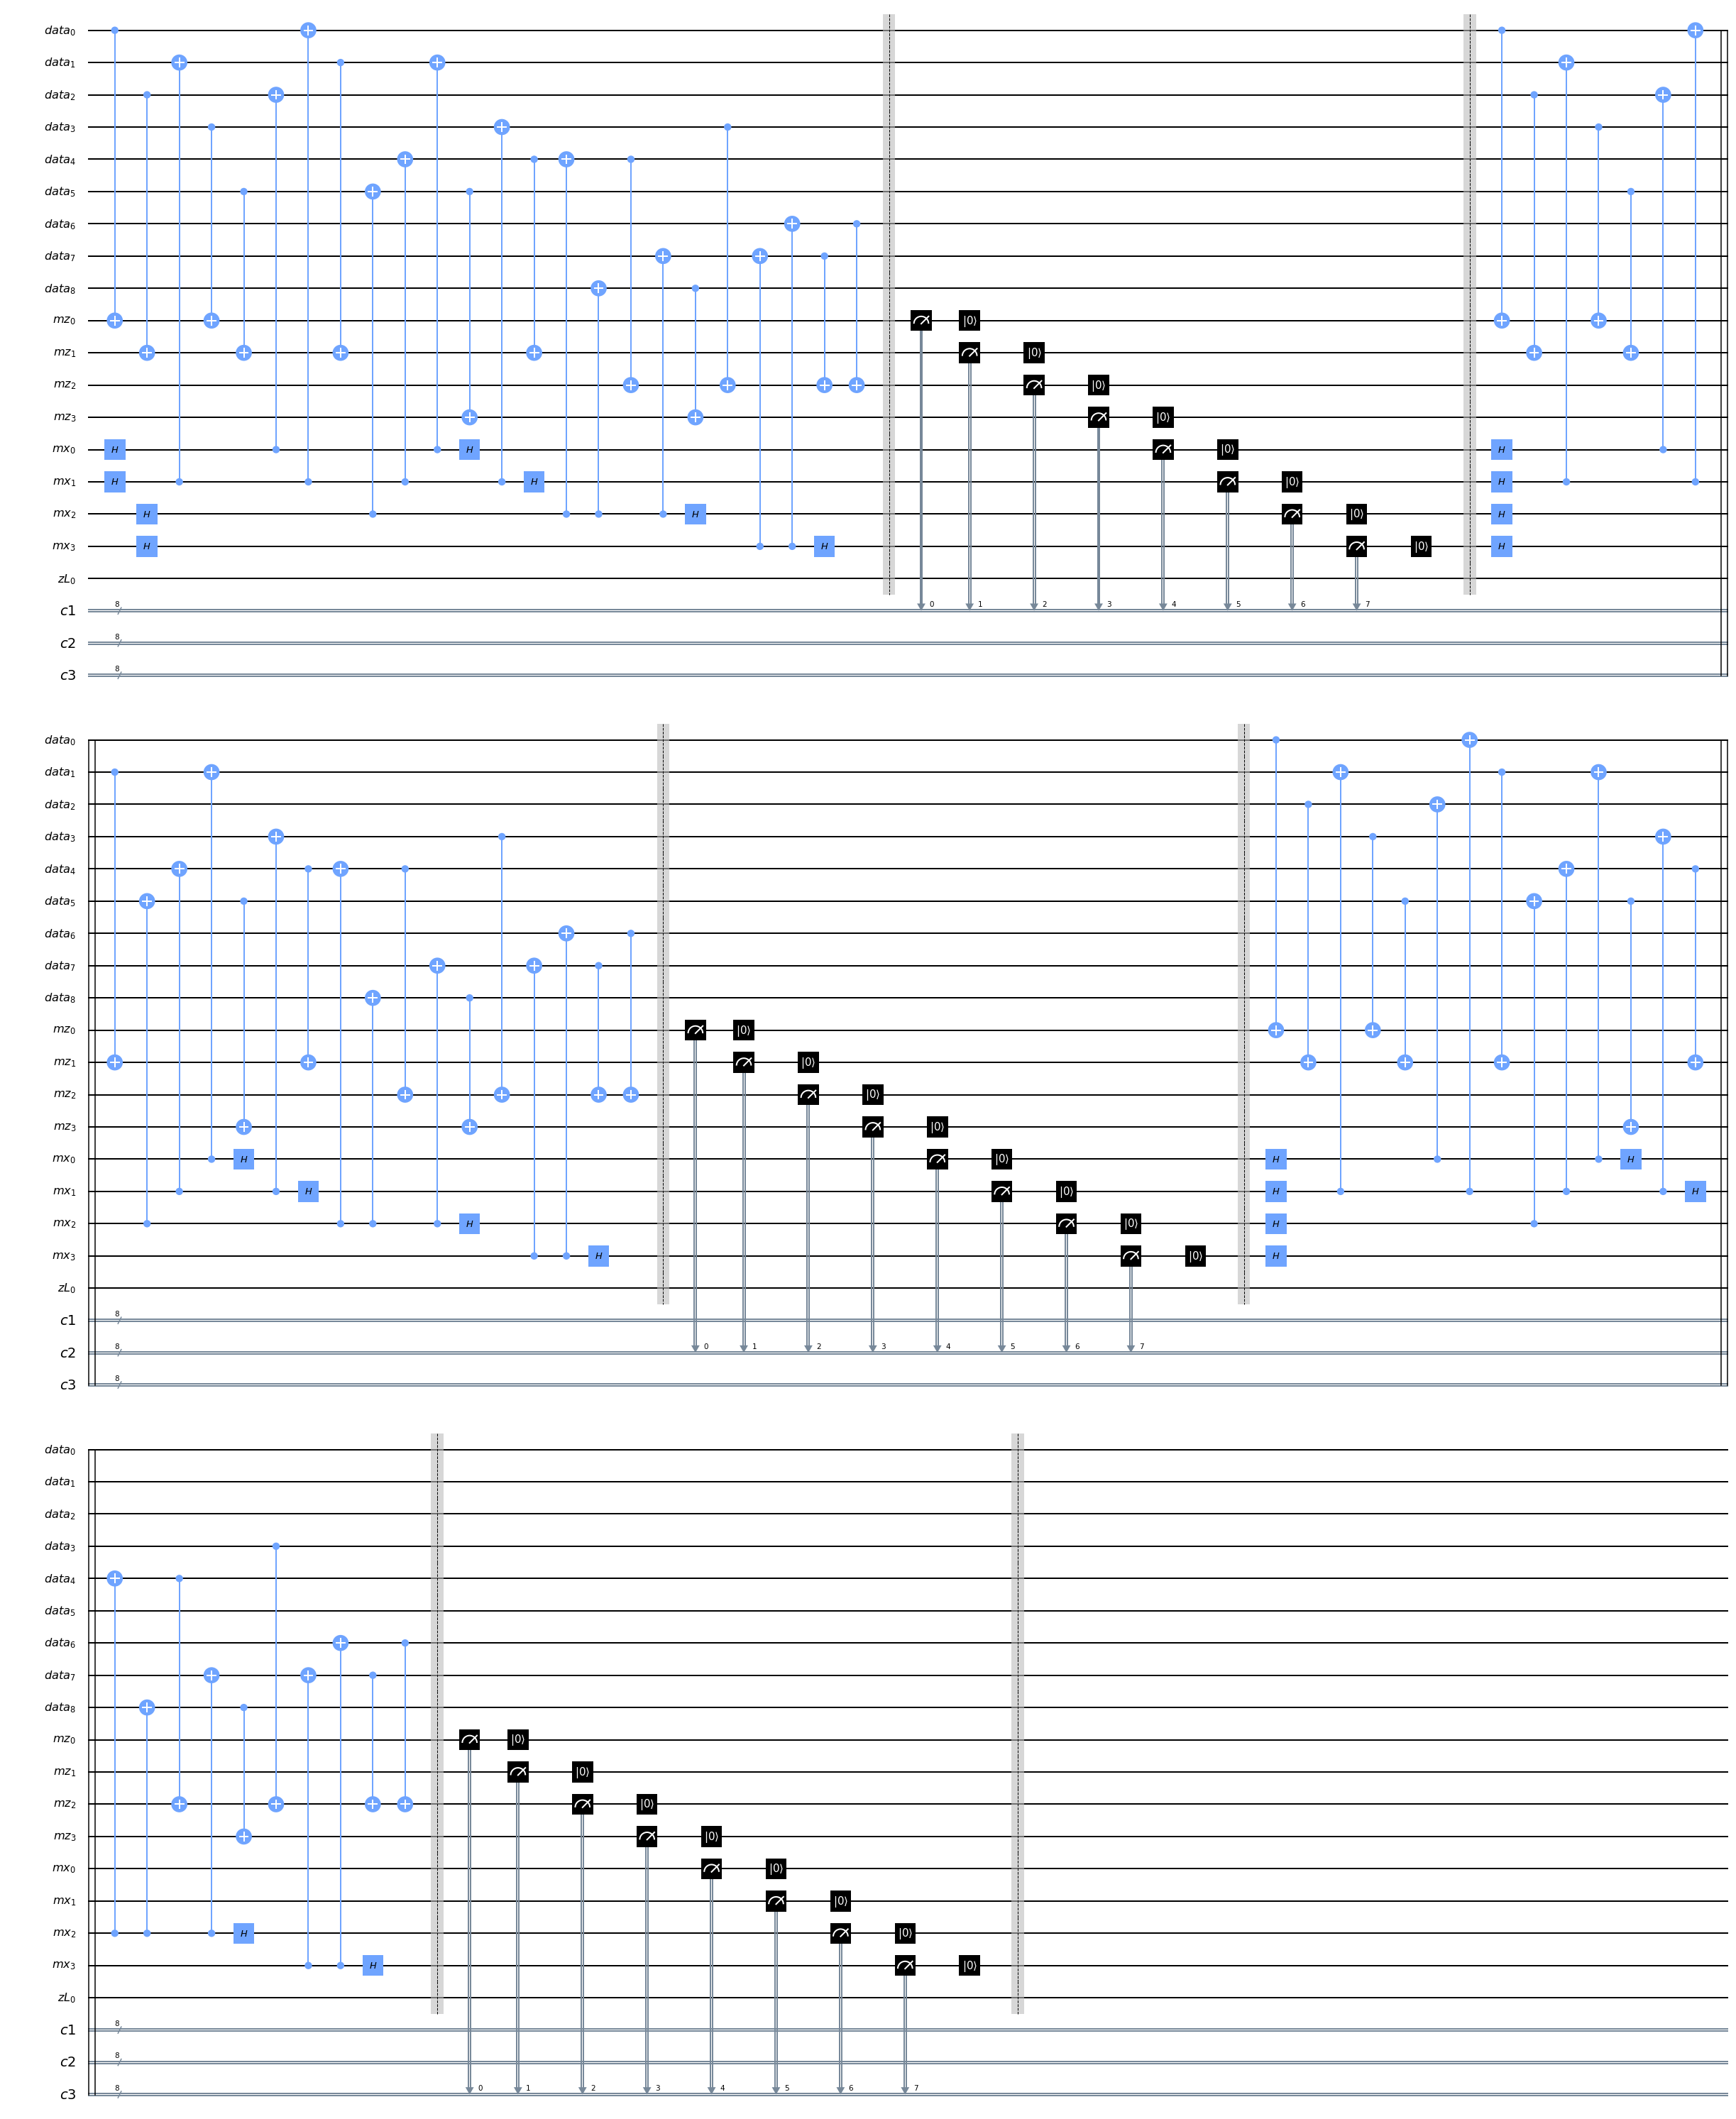

In [25]:
data = QuantumRegister(9, name='data')
mx = QuantumRegister(4, name='mx')
mz = QuantumRegister(4, name='mz')

rounds=2  # The actual number of rounds will always be more than 1, since the first round creates the quiescent state
measurements = [ClassicalRegister(8, name="c{}".format(i+1)) for i in range(rounds + 1)]
Z_logical = QuantumRegister(1, name="zL")

circ = QuantumCircuit(data, mz, mx, *measurements, Z_logical)
# [circ.x(i) for i in data]
def stabilize(circ, i):
    # Top left
    circ.h(mx[1])
    circ.cx(mx[1], data[1])
    circ.cx(data[0], mz[0])
    circ.cx(mx[1], data[0])
    circ.cx(mx[1], data[4])
    circ.cx(data[3], mz[0])
    circ.cx(mx[1], data[3])
    circ.h(mx[1])

    # Top right
    circ.h(mx[0])
    circ.cx(data[2], mz[1])
    circ.cx(data[5], mz[1])
    circ.cx(data[1], mz[1])
    circ.cx(data[4], mz[1])
    circ.cx(mx[0], data[2])
    circ.cx(mx[0], data[1])
    circ.h(mx[0])

    # Bottom right
    circ.h(mx[2])
    circ.cx(mx[2], data[5])
    circ.cx(mx[2], data[4])
    circ.cx(mx[2], data[8])
    circ.cx(mx[2], data[7])
    circ.cx(data[5], mz[3])
    circ.cx(data[8], mz[3])
    circ.h(mx[2])

    # Bottom left
    circ.h(mx[3])
    circ.cx(mx[3], data[7])
    circ.cx(mx[3], data[6])
    circ.cx(data[4], mz[2])
    circ.cx(data[3], mz[2])
    circ.cx(data[7], mz[2])
    circ.cx(data[6], mz[2])
    circ.h(mx[3])
    circ.barrier()

    circ.measure(mz, measurements[i][0:4])
    circ.measure(mx, measurements[i][4:8])
    circ.reset(mz)
    circ.reset(mx)
    circ.barrier()


stabilize(circ, 0)
stabilize(circ, 1)
circ
stabilize(circ, 2)

circ.draw(output='mpl', fold=50)

Just like before, the $XXXX$ measurements will project our starting state into a quiescent state. Similarly, the $ZZZZ$ measurement doesn't do anything here, since both the starting state and the quiescent states are already Z-eigenstates.

We make four different $XXXX$ measurements, and each has two eigenvalues, so in this case there are $2^4 = 16$ possible combinations of syndrome measurements.

We can run this on the simulator and confirm. We see 3 groups of 8 bits, which are the syndrome measurement rounds. These are stable, and the first 4 bits permute through the 16 possible $XXXX$ syndromes:

In [5]:
execute(circ, Aer.get_backend('qasm_simulator')).result().get_counts()

{'01110000 01110000 01110000': 74,
 '10100000 10100000 10100000': 56,
 '11110000 11110000 11110000': 72,
 '01010000 01010000 01010000': 63,
 '01000000 01000000 01000000': 61,
 '10110000 10110000 10110000': 66,
 '11000000 11000000 11000000': 65,
 '00110000 00110000 00110000': 58,
 '11100000 11100000 11100000': 76,
 '00010000 00010000 00010000': 47,
 '00100000 00100000 00100000': 68,
 '10010000 10010000 10010000': 74,
 '00000000 00000000 00000000': 53,
 '01100000 01100000 01100000': 75,
 '11010000 11010000 11010000': 58,
 '10000000 10000000 10000000': 58}

**TODO: Describe details of logical codespace definition**

From Decodoku posts by James Wooten:

http://decodoku.blogspot.com/2016/03/6-toric-code-part-2.html

<p align="center">
<img width="290" alt="torus" src="https://1.bp.blogspot.com/-Ws0KSLZI57o/Vt_8-w4u15I/AAAAAAAAAJM/KgTj-zACm3M/s1600/torus.png">
<img width="640" alt="logical-qubit" src="https://3.bp.blogspot.com/-W88UDHv8Jyw/VugssfkcRkI/AAAAAAAAAKI/VL1MyGq_WE0MPXAqfCYACeZcoTw304ekg/s640/6.png">
</p>

In our circuit, the Z-operator can be picked as any row of data qubits. We choose the top row:

In [61]:
logical_zero = circ.copy()

Z_logical_readout = ClassicalRegister(1, name="zLR")
logical_zero.add_register(Z_logical_readout)

# The Z-logical readout
logical_zero.cx(data[0], Z_logical)
logical_zero.cx(data[1], Z_logical)
logical_zero.cx(data[2], Z_logical)
logical_zero.measure(Z_logical, Z_logical_readout)

In [62]:
execute(logical_zero, Aer.get_backend('qasm_simulator')).result().get_counts()

{'0 11000000 11000000 11000000': 58,
 '0 01010000 01010000 01010000': 60,
 '0 10010000 10010000 10010000': 74,
 '0 10110000 10110000 10110000': 72,
 '0 11100000 11100000 11100000': 50,
 '0 00100000 00100000 00100000': 67,
 '0 00010000 00010000 00010000': 65,
 '0 01110000 01110000 01110000': 61,
 '0 00110000 00110000 00110000': 62,
 '0 01100000 01100000 01100000': 64,
 '0 11010000 11010000 11010000': 68,
 '0 11110000 11110000 11110000': 57,
 '0 00000000 00000000 00000000': 61,
 '0 10000000 10000000 10000000': 75,
 '0 01000000 01000000 01000000': 59,
 '0 10100000 10100000 10100000': 71}

**TODO: Explain X operator?**

Applying the X operator, we can get a $|1_L\rangle$ state:

In [68]:
logical_one = circ.copy()
logical_one.add_register(Z_logical_readout)

logical_one.x(data[0])
logical_one.x(data[3])
logical_one.x(data[6])

stabilize(logical_one, 2)
logical_one.reset(Z_logical)
logical_one.cx(data[0], Z_logical)
logical_one.cx(data[1], Z_logical)
logical_one.cx(data[2], Z_logical)
logical_one.measure(Z_logical, Z_logical_readout)

In [69]:
execute(logical_one, Aer.get_backend('qasm_simulator')).result().get_counts()

{'1 00000000 00000000 00000000': 67,
 '1 01010000 01010000 01010000': 69,
 '1 11000000 11000000 11000000': 54,
 '1 11110000 11110000 11110000': 57,
 '1 10010000 10010000 10010000': 76,
 '1 11100000 11100000 11100000': 61,
 '1 11010000 11010000 11010000': 59,
 '1 10000000 10000000 10000000': 59,
 '1 10100000 10100000 10100000': 60,
 '1 01000000 01000000 01000000': 66,
 '1 00110000 00110000 00110000': 64,
 '1 01110000 01110000 01110000': 58,
 '1 00100000 00100000 00100000': 66,
 '1 10110000 10110000 10110000': 74,
 '1 01100000 01100000 01100000': 60,
 '1 00010000 00010000 00010000': 74}

## Manual d=3 Surface Code with 17 Qubits (Nov 2)

In [113]:
# [circ.x(i) for i in data]
def stabilize(circ, i):
    # Top left
    circ.h(mx[0])
    circ.cx(mx[0], data[1])
    circ.cx(mx[0], data[0])
    circ.cx(data[1], mz[0])
    circ.cx(data[0], mz[0])
    circ.cx(data[4], mz[0])
    circ.cx(data[3], mz[0])
    circ.h(mx[0])
    
    # Top right
    circ.h(mx[1])
    circ.cx(mx[1], data[2])
    circ.cx(mx[1], data[1])
    circ.cx(mx[1], data[5])
    circ.cx(mx[1], data[4])
    circ.cx(data[2],mz[1])
    circ.cx(data[5],mz[1])
    circ.h(mx[1])
    
    # Bottom left
    circ.h(mx[2])
    circ.cx(data[3], mz[2])
    circ.cx(data[6], mz[2])
    circ.cx(mx[2], data[4])
    circ.cx(mx[2], data[3])
    circ.cx(mx[2], data[7])
    circ.cx(mx[2], data[6])
    circ.h(mx[2])

    # Bottom right
    circ.h(mx[3])
    circ.cx(mx[3], data[8])
    circ.cx(mx[3], data[7])
    circ.cx(data[5], mz[3])
    circ.cx(data[4], mz[3])
    circ.cx(data[8], mz[3])
    circ.cx(data[7], mz[3])
    circ.h(mx[3])
    circ.barrier()

    circ.measure(mz, measurements[i][0:4])
    circ.measure(mx, measurements[i][4:8])
    circ.reset(mz)
    circ.reset(mx)
    circ.barrier()

In [114]:
data = QuantumRegister(9, name='data')
mx = QuantumRegister(4, name='mx')
mz = QuantumRegister(4, name='mz')

rounds=2  # The actual number of rounds will always be more than 1, since the first round creates the quiescent state
measurements = [ClassicalRegister(8, name="c{}".format(i+1)) for i in range(rounds + 1)]
logical = QuantumRegister(1, name="logical")

base_circ = QuantumCircuit(data, mz, mx, *measurements, logical)

def get_stabilized_circ(base_circuit, rounds):
    circ = base_circuit.copy()
    for i in range(rounds + 1):
        stabilize(circ, i)
    return circ

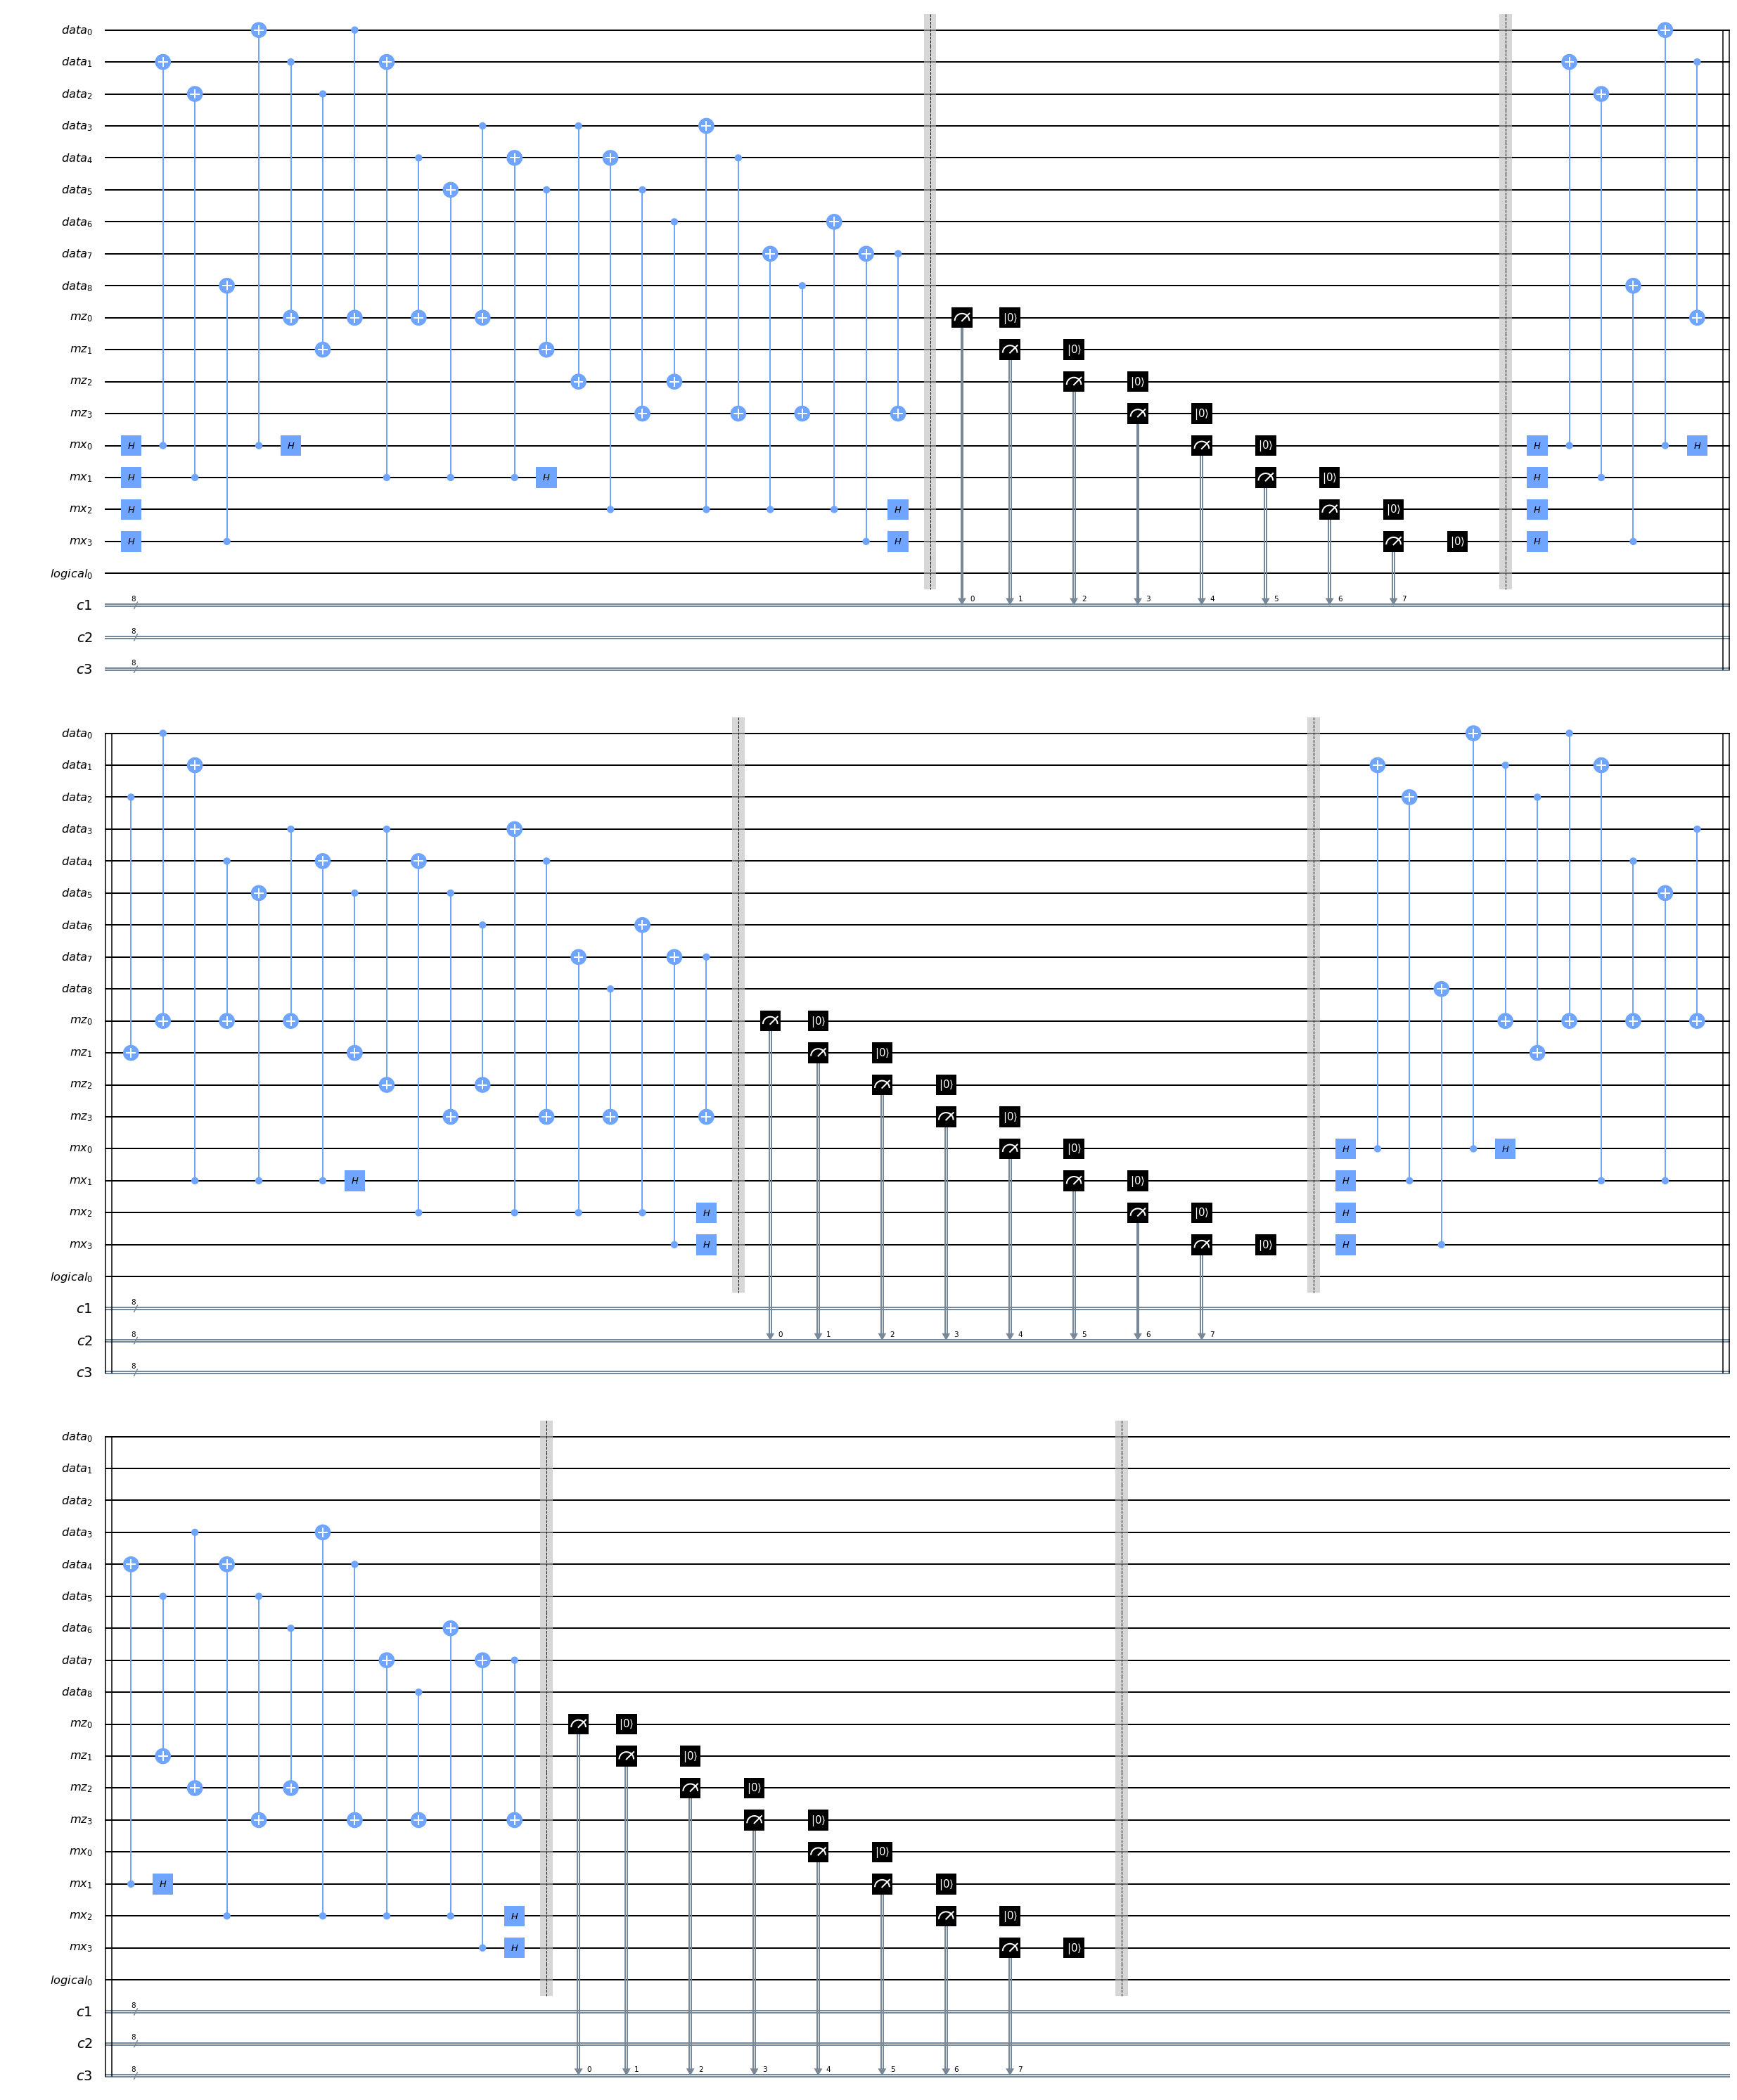

In [115]:
circ = get_stabilized_circ(base_circ, rounds)
circ.draw(output='mpl', fold=50)

In [116]:
execute(circ, Aer.get_backend('qasm_simulator')).result().get_counts()

{'01110000 01110000 01110000': 73,
 '10100000 10100000 10100000': 75,
 '11110000 11110000 11110000': 58,
 '01010000 01010000 01010000': 63,
 '01000000 01000000 01000000': 72,
 '10110000 10110000 10110000': 51,
 '11000000 11000000 11000000': 62,
 '00110000 00110000 00110000': 63,
 '11100000 11100000 11100000': 48,
 '00010000 00010000 00010000': 69,
 '00100000 00100000 00100000': 64,
 '10010000 10010000 10010000': 65,
 '00000000 00000000 00000000': 62,
 '01100000 01100000 01100000': 65,
 '11010000 11010000 11010000': 70,
 '10000000 10000000 10000000': 64}

In [117]:
# Z READOUT
logical_zero = circ.copy()

logical_readout = ClassicalRegister(1, name="logicalR")
logical_zero.add_register(logical_readout)

# The Z-logical readout
logical_zero.reset(logical)
logical_zero.cx(data[0], logical)
logical_zero.cx(data[1], logical)
logical_zero.cx(data[2], logical)
logical_zero.measure(logical, logical_readout)

print(execute(logical_zero, Aer.get_backend('qasm_simulator')).result().get_counts())

{'0 01110000 01110000 01110000': 61, '0 10100000 10100000 10100000': 64, '0 11110000 11110000 11110000': 70, '0 01010000 01010000 01010000': 52, '0 01000000 01000000 01000000': 53, '0 10110000 10110000 10110000': 70, '0 11000000 11000000 11000000': 69, '0 00110000 00110000 00110000': 79, '0 11100000 11100000 11100000': 56, '0 00010000 00010000 00010000': 70, '0 00100000 00100000 00100000': 67, '0 10010000 10010000 10010000': 58, '0 00000000 00000000 00000000': 67, '0 01100000 01100000 01100000': 65, '0 11010000 11010000 11010000': 59, '0 10000000 10000000 10000000': 64}


In [126]:
logical_one = circ.copy()
logical_readout = ClassicalRegister(1, name="logicalR")
logical_one.add_register(logical_readout)

# Logical X
logical_one.x(data[0])
# logical_one.x(data[3])
# logical_one.x(data[6])

# The Z-logical readout
# stabilize(logical_one, 2)
logical_one.reset(logical)
logical_one.cx(data[0], logical)
logical_one.cx(data[1], logical)
logical_one.cx(data[2], logical)
logical_one.measure(logical, logical_readout)

print(execute(logical_one, Aer.get_backend('qasm_simulator')).result().get_counts())

{'1 01100000 01100000 01100000': 54, '1 10000000 10000000 10000000': 56, '1 01010000 01010000 01010000': 58, '1 11000000 11000000 11000000': 68, '1 10100000 10100000 10100000': 57, '1 00010000 00010000 00010000': 70, '1 11110000 11110000 11110000': 55, '1 11010000 11010000 11010000': 61, '1 00100000 00100000 00100000': 75, '1 00110000 00110000 00110000': 61, '1 01110000 01110000 01110000': 62, '1 01000000 01000000 01000000': 66, '1 10010000 10010000 10010000': 68, '1 11100000 11100000 11100000': 78, '1 10110000 10110000 10110000': 67, '1 00000000 00000000 00000000': 68}


In [119]:
logical_plus = base_circ.copy()
logical_readout = ClassicalRegister(1, name="logicalR")
logical_plus.add_register(logical_readout)

# Initialize Data qubits in |+>
for i in range(9):
    logical_plus.reset(data[i])
    logical_plus.h(data[i])

# Stabilize
logical_plus = get_stabilized_circ(logical_plus, rounds)

# The X-logical readout
logical_plus.reset(logical)
logical_plus.h(logical)
logical_plus.cx( logical, data[0])
logical_plus.cx( logical, data[3])
logical_plus.cx( logical, data[6])
logical_plus.h(logical)
logical_plus.measure(logical, logical_readout)

print(execute(logical_plus, Aer.get_backend('qasm_simulator')).result().get_counts())
# logical_plus.draw(output='mpl', fold=50)

{'0 00001010 00001010 00001010': 63, '0 00000111 00000111 00000111': 61, '0 00000001 00000001 00000001': 49, '0 00001101 00001101 00001101': 61, '0 00001011 00001011 00001011': 65, '0 00000100 00000100 00000100': 71, '0 00001111 00001111 00001111': 67, '0 00000110 00000110 00000110': 61, '0 00000101 00000101 00000101': 84, '0 00000000 00000000 00000000': 81, '0 00001001 00001001 00001001': 61, '0 00000011 00000011 00000011': 58, '0 00000010 00000010 00000010': 52, '0 00001100 00001100 00001100': 51, '0 00001110 00001110 00001110': 77, '0 00001000 00001000 00001000': 62}


In [120]:
logical_minus = base_circ.copy()
logical_readout = ClassicalRegister(1, name="logicalR")
logical_minus.add_register(logical_readout)

# Initialize Data qubits in |+>
for i in range(9):
    logical_minus.reset(data[i])
    logical_minus.h(data[i])

# Stabilize
logical_minus = get_stabilized_circ(logical_minus, rounds)

# Logical Z
logical_minus.z(data[0])
logical_minus.z(data[1])
logical_minus.z(data[2])

# The X-logical readout
logical_minus.reset(logical)
logical_minus.h(logical)
logical_minus.cx( logical, data[0])
logical_minus.cx( logical, data[3])
logical_minus.cx( logical, data[6])
logical_minus.h(logical)
logical_minus.measure(logical, logical_readout)

print(execute(logical_minus, Aer.get_backend('qasm_simulator')).result().get_counts())
# logical_plus.draw(output='mpl', fold=50)

{'1 00000111 00000111 00000111': 66, '1 00000000 00000000 00000000': 64, '1 00001010 00001010 00001010': 53, '1 00001001 00001001 00001001': 59, '1 00001111 00001111 00001111': 54, '1 00000101 00000101 00000101': 69, '1 00001110 00001110 00001110': 71, '1 00001101 00001101 00001101': 74, '1 00000001 00000001 00000001': 57, '1 00000100 00000100 00000100': 76, '1 00000010 00000010 00000010': 56, '1 00000011 00000011 00000011': 68, '1 00001100 00001100 00001100': 65, '1 00001000 00001000 00001000': 67, '1 00000110 00000110 00000110': 70, '1 00001011 00001011 00001011': 55}


# Circuit Generation for Surface Codes

Surface Codes are CSS codes which encode logical states in a two dimensional lattice of qubits. Syndromes are measured along all the different squares as $X_1 X_2 Z_1 Z_2$ on each edge.

The graph below is a surface code patch of distance d=3 such that number of qubits required is $d^2$ and number of syndrom qubits required is $d^2-1$. Here, blue patches are Z stabilizers and red patches are X stabilizers. Z stabilizers entangle qubits on data qubits (grey) in corners as control, with syndrome qubits (black) in the centre as target.

Similarly, X stabilizers entangle qubits with controlled not on data qubits (grey) in corners as target, with syndrome qubits (black) in the centre as control. The Z and N marked in each patch determines the order of CX labeled in black. Grey coordinate labels are data qubit locations and black labels are syndrome qubit locations.

The straight line marked Z<sub>L</sub> signifies that a logical Z is applied by operating Z on each qubit, on any horizontal line in the lattice. Similarly, the straight line marked X<sub>L</sub> signifies that a logical X is applied by operating X on each qubit, on any vertical line in the lattice. We choose one convention and say top edge signifies a Z logical operation and left edge signifies X logical operation! 

<p align="center">
<img width="672" alt="Lattice" src="https://user-images.githubusercontent.com/293681/86267952-7541f700-bb95-11ea-8292-240bf344f7f8.png">
</p>

The code assigns node locations to the lattices using `SurfaceCode(d, T).lattice()` and then assigns the order of controlled not for each square using `SurfaceCode(d, T).connection()`. This is then used by the syndrome measurement to apply controlled nots for each square according to the numbers and type of stabilizer the square execute (red: X, blue:Z). 

Thus, the above circuit is created and each syndrome qubit is measured. This is called syndrome measurement and is repeated T=d times. The results from each syndrome measurement are then processed to extract error nodes i.e. nodes which were flipped in consecutive syndrome measurements. This information is then utilised by the classes in syndrome_graph and fitter.py files to create error graphs and perform matching (see the [decoder tutorial](2_surface_code_decoding.ipynb)) to deduce the most probable error.

Finally, logical Z error is concluded by checking if there were odd number of qubits with errors on top (Z<sub>L</sub>) edge and logical X error is concluded if there odd number of qubits with errors on the left (X<sub>L</sub>) edge

# Visualize the SurfaceEncoder Circuit

Each round of the syndrome measurement runs the following measurements between the ancilla qubits on top and the N,S,E,W data qubits:

<p align="center">
<img width="549" alt="Screen Shot 2020-07-01 at 3 43 38 PM" src="https://user-images.githubusercontent.com/293681/86285090-02934480-bbb2-11ea-8b18-57eda706b206.png">
</p>

- Wang, D. S., Fowler, A. G., Stephens, A. M. & Hollenberg, L. C. L. Threshold error rates for the toric and surface codes. arXiv:0905.0531 [quant-ph] (2009).

We can visualize the output of the "linearized" circuit in Qiskit (below):

In [ ]:
code.circuit["0"].draw(output='mpl', fold=50)

In [ ]:
execute(code.circuit["0"], Aer.get_backend('qasm_simulator'), shots=1).result().get_counts()

#   Circuit Execution (Logical 0)


In [ ]:
import sys
sys.path.insert(0, '../')
from surface_code.circuits import SurfaceCode

# Set up a d=3, T=3 code
code = SurfaceCode(3, 3)
job = execute(code.circuit['0'], Aer.get_backend('qasm_simulator'))

raw_results = {}
raw_results['0'] = job.result().get_counts()

processed_results={}
processed_results=code.process_results(raw_results['0'])

j=0
for i in (processed_results):
    print("results from circuit execution round",j,":", processed_results[2])
    j=j+1
    
nodesX,nodesZ = code.extract_nodes(processed_results)
print("error nodes in X", nodesX)
print("error nodes in Z", nodesZ)
print("No Z error as logical 0 state is an eigenstate of logical Z (given no noise is added to the system)")